In [ ]:
import sys
sys.path.append("../src/")

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

%matplotlib inline

In [ ]:
import data_loader as dl
from draw import DRAW
from numpy_filterbank import filterbank

Using TensorFlow backend.


In [ ]:
x_full, x_labeled, y = dl.load_simulated("128")
#(x_full, _), (x_labeled, y) = tf.keras.datasets.mnist.load_data()
y = y if len(y.shape) == 1 else y.argmax(1)
#x_full = np.expand_dims(x_full, -1)/ 255
#x_labeled = np.expand_dims(x_labeled, -1)/ 255

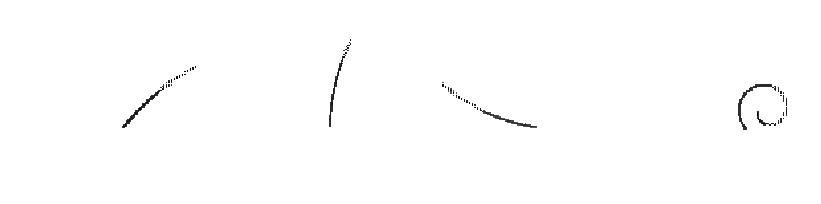

In [ ]:
"""
The data comes in the form of images, we'll display a couple for clarity
"""
%matplotlib inline
fig, axs = plt.subplots(ncols=4, figsize=(14, 5))
og_events = [x_full[i].reshape(x_full[i].shape[0], x_full[i].shape[1]) for i in range(4)]
[axs[i].imshow(og_events[i], cmap="Greys") for i in range(4)]
[axs[i].axis("off") for i in range(4)]
plt.show()

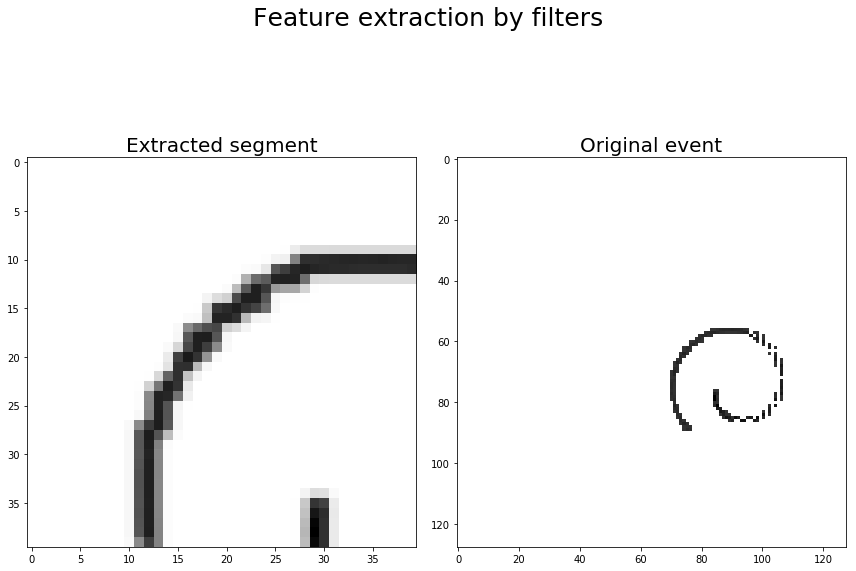

In [ ]:
"""
The attention parameter delta and the number of filters N 
determines the amount of data seen at each time-step, when
using attention.
"""
ref_event = og_events[3]
gx = (128 + 1)/2 * 1.2
gy = (128 + 1)/2 * 1
sigma = 0.2
delta = 0.8
gamma = 1
N = 40
fb = filterbank(*x_full.shape[1:-1])
Fx, Fy = fb.filters(gx, gy, sigma, delta, gamma, N)
filtered = np.einsum("ijk, kl, lm->jm", Fy, ref_event, np.squeeze(np.transpose(Fx, [0, 2, 1])))

fig, ax = plt.subplots(ncols=2, figsize=(12, 10))
fig.suptitle("Feature extraction by filters", fontsize=25)
ax[0].imshow(np.squeeze(filtered), cmap="Greys")
ax[0].set_title("Extracted segment", fontsize=20)

ax[1].imshow(ref_event,  cmap="Greys")
ax[1].set_title("Original event", fontsize=20)
plt.tight_layout()
plt.savefig("/home/robersol/github/thesis/chapters/methods/models/draw/filtered.pdf")
plt.savefig("/home/robersol/github/thesis/chapters/methods/models/draw/filtered.png")

In [ ]:
T = 3
enc_size = 256
dec_size = 256
latent_dim = 3
use_attn = False
if use_attn:
    delta_write = delta
    delta_read = delta
    read_N = N
    write_N = N
    attn_config = {
        "read_N": read_N,
        "write_N": write_N,
        "write_N_sq": write_N ** 2,
        "delta_w": delta_write,
        "delta_r": delta_read,
    }
    conv_config = None
    use_conv = None
else:
    n_layers = 4
    kernel_architecture = [5, 5, 3, 3]
    filter_architecture = [32, 16, 8, 4]
    strides_architecture = [2, 2, 2, 2]
    pool_architecture = [0, 0, 0, 0]
    conv_config = {
        "n_layers":n_layers,
        "kernel_size":kernel_architecture,
        "filters":filter_architecture,
        "strides":strides_architecture,
        "pool":pool_architecture,
    }
    attn_config = None
    use_conv = True
    
mode_config = {
    "simulated_mode":False, #deprecated, to be removed
    "restore_mode":False, #indicates whether to load weights 
    "include_KL":False, #whether to compute the KL loss over the latent space
    "include_MMD":False, #same as above, but MMD 
    "include_KM":False, #same as above, but K-means. See thesis for a more in-depth treatment of these
    "batchnorm":False, #whether to include batch-normalization between layers
    "use_vgg":False, #whether the input data is from a pre-trained model 
    "use_dd":False, #whether to use the dueling-decoder objective 
}

model = DRAW(
    T,
    dec_size,
    enc_size,
    latent_dim,
    x_full.shape,
    beta=1,
    use_attention=use_attn,
    attn_config=attn_config,
    use_conv=use_conv,
    conv_architecture=conv_config,
    mode_config=mode_config
)

In [ ]:
graph_kwds = {
    "activation": "lrelu",
    "output_activation": "sigmoid",
    "kernel_reg_strength": 1e-8,
}
loss_kwds = {
    "reconst_loss": None
}
model.compile_model(graph_kwds, loss_kwds)

conv shape:  (?, 64, 64, 32)
conv shape:  (?, 32, 32, 16)
conv shape:  (?, 16, 16, 8)
conv shape:  (?, 8, 8, 4)
Final shape:  256
Deconv shape:  (?, 16, 16, 8)
Deconv shape:  (?, 32, 32, 16)
Deconv shape:  (?, 64, 64, 32)
Deconv shape:  (?, 128, 128, 1)


In [ ]:
optimizer = tf.train.AdamOptimizer
opt_args = [1e-4, ] #learning rate
opt_kwargs = {"beta1": 0.8, "beta2":0.99}
model.compute_gradients(optimizer, opt_args, opt_kwargs)

In [ ]:
epochs = 200
batch_size = 100
earlystop = True
sess = tf.InteractiveSession()

lx, lz = model.train(
    x_full,
    sess,
    epochs,
    batch_size,
    earlystopping=earlystop
)

RUN NR 0
Removed: ../loss_records/tensorboard/run_0/events.out.tfevents.1569082825.ml2
starting training..


In [19]:
"""
To explore the model status we can run intermediate aspects of interest of the graph
First, we confirm that the reconstructions are sane.
"""
sample = x_full[:4].reshape((4, -1))
feed_dict = {model.x:sample}
reconstructions = np.array(model.sess.run(model.canvas_seq, feed_dict))
print(reconstructions.shape)
reconstructions = reconstructions.reshape((T, 4,x_full.shape[1], x_full.shape[2]))

(3, 4, 16384)


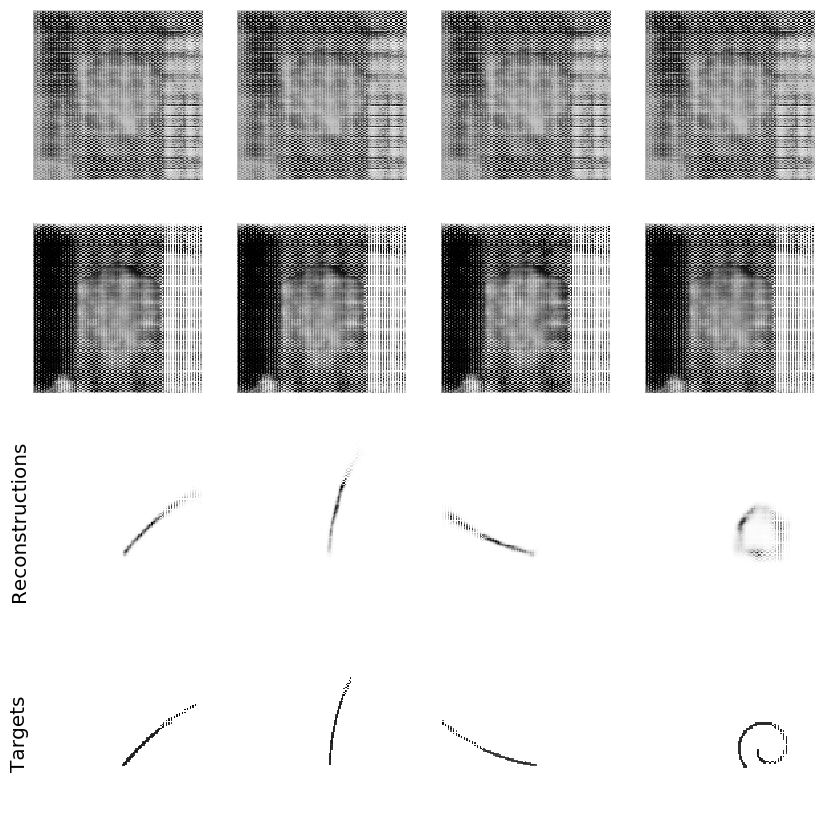

In [39]:
fig, ax = plt.subplots(ncols=4, nrows=T+1, figsize=(14, T*5))

for t in range(T):
    canvasses = reconstructions[t]
    if t < (T-1):
        canvasses = 1/(1 + np.exp(-canvasses))
        [ax[t][i].axis("off")for i in range(4)]
    else:
        [ax[t,i].xaxis.set_visible(False) for i in range(4)]
        [ax[t,i].tick_params(left=False, labelleft=False)  for i in range(4)]
        [ax[t,i].tick_params(left=False, labelleft=False)]
        [plt.setp(ax[t,i].spines.values(), visible=False) for i in range(4)]
        ax[t, 0].set_ylabel("Reconstructions", fontsize=20)
    [a.imshow(canvas, cmap="Greys") for a, canvas in zip(ax[t], canvasses)]
    
[a.imshow(og_event, cmap="Greys") for a, og_event in zip(ax[-1], og_events)]
[ax[-1,i].xaxis.set_visible(False) for i in range(4)]
[ax[-1,i].tick_params(left=False, labelleft=False)  for i in range(4)]
[ax[-1,i].tick_params(left=False, labelleft=False)]
[plt.setp(ax[-1,i].spines.values(), visible=False) for i in range(4)]
ax[-1, 0].set_ylabel("Targets", fontsize=20)

plt.savefig("/home/robersol/github/thesis/chapters/methods/models/draw/reconst.pdf")
plt.savefig("/home/robersol/github/thesis/chapters/methods/models/draw/reconst.png")

In [21]:
all_labeled = x_labeled.reshape((x_labeled.shape[0], -1))
latent_labeled = np.array(model.run_large(sess, model.z_seq, all_labeled))
latent_labeled = np.transpose(latent_labeled, [1, 0, 2])
latent_labeled = latent_labeled.reshape((latent_labeled.shape[0], -1))
latent_labeled_project = TSNE(2).fit_transform(latent_labeled)

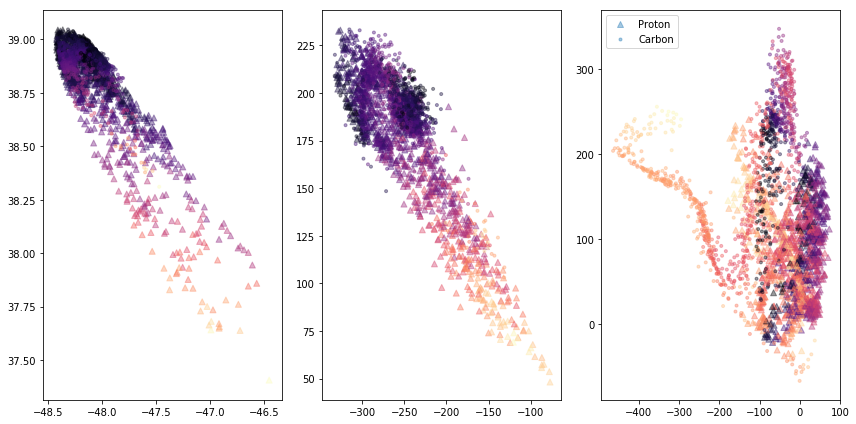

In [27]:
"""
Secondly we want to inspect the latent space to investigate if we can visually 
identify a relationship. We chose the latent dimension to be 2 to give an easy 
visualization. We observe that there is a very good class separation in the space.
"""

fig, axs = plt.subplots(figsize=(4*T, 6), ncols=T)
cm = matplotlib.cm.get_cmap("magma")

physics = ["Proton", "Carbon"]
markers = ["^", "."]
mnist = ["{}".format(i) for i in range(len(np.unique(y)))]
classes = physics if len(np.unique(y)) == 2 else mnist

for i in range(T):
    ax = axs[i]
    for c in np.unique(y):
        t = 3*i
        which = y == c
        latent = latent_labeled[which]
        ax.scatter(
            latent[:,0+t],
            latent[:,1+t],
            marker=markers[c],
            label=classes[c],
            alpha=0.4,
            c=latent[:,2+t],
            cmap="magma"
            #c=colors[c],
        )

plt.legend()
plt.tight_layout()
plt.savefig("/home/robersol/github/thesis/chapters/methods/models/draw/latent.pdf")
plt.savefig("/home/robersol/github/thesis/chapters/methods/models/draw/latent.png")

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr_train, lr_test, y_train, y_test = train_test_split(latent_labeled, y)
lr_model = LogisticRegression(solver="lbfgs", class_weight="balanced", max_iter=1000)
lr_model.fit(lr_train, y_train)
print("Model accuracy: {:.2f}".format(lr_model.score(lr_test, y_test)))

Model accuracy: 0.94
